In [16]:
import os
import numpy as np
import pandas as pd
import cv2 # OpenCV
from alive_progress import alive_bar
import time
from pathlib import Path
from sklearn.svm import SVC # SVM klasifikator
from skimage.feature import hog as HOG
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

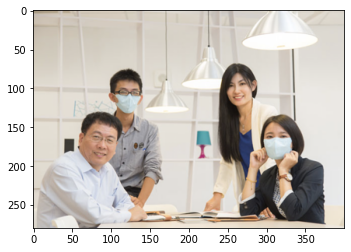

In [17]:
mask_on_classifier = pickle.load(open('mask_on_classifier.sav', 'rb'))
img_base_path = str(Path().absolute()) + "\\archive\\images\\"
image = cv2.imread(img_base_path + "maksssksksss96.png")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [18]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

def classify_window(window):
    features = HOG(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True).reshape(1, -1)
    result = mask_on_classifier.predict_proba(features);
    #if result[0][0] > 0.5:
    #    return result[0][1]
    return result[0][1]

In [19]:
def process_image(image, step_size, window_size=(40, 40), threshold=0.9):

    result_scores = []
    result_windows = []
    
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0], 3):
                score = classify_window(window)
                if score > threshold:
                    print(score)
                    result_scores.append(score)
                    result_windows.append(this_window)
    return result_scores, result_windows

In [20]:
def jaccard_index(true_box, predicted_box):
    y_a = max(true_box[0], predicted_box[0])
    x_a = max(true_box[1], predicted_box[1])
    y_b = min(true_box[2], predicted_box[2])
    x_b = min(true_box[3], predicted_box[3])
    
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    
    true_area = (true_box[3] - true_box[1] + 1) * (true_box[2] - true_box[0] + 1)

    pred_area = (predicted_box[3] - predicted_box[1] + 1) * (predicted_box[2] - predicted_box[0] + 1)
    
    iou = inter_area / float(true_area + pred_area - inter_area)
    
    return max(iou, 0)

In [21]:

score, score_window = process_image(image, step_size=10)

0.9246589969567317
0.9528659464809136
0.9999824214033085
0.9999819224253834
0.9486591423600517
0.9871905165315826
0.9546977848686777
0.9096899528588426


[0.9246589969567317, 0.9528659464809136, 0.9999824214033085, 0.9999819224253834, 0.9486591423600517, 0.9871905165315826, 0.9546977848686777, 0.9096899528588426]
[(80, 100), (80, 250), (90, 100), (150, 70), (150, 290), (160, 70), (170, 70), (200, 110)]


"\nface_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')\n\nimg = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)\n\nfaces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples\n\nout_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image\n\n#plotting\nfor (x,y,w,h) in faces:\n    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,250,0),1)\nplt.figure(figsize=(12,12))\nplt.imshow(out_img)\n"

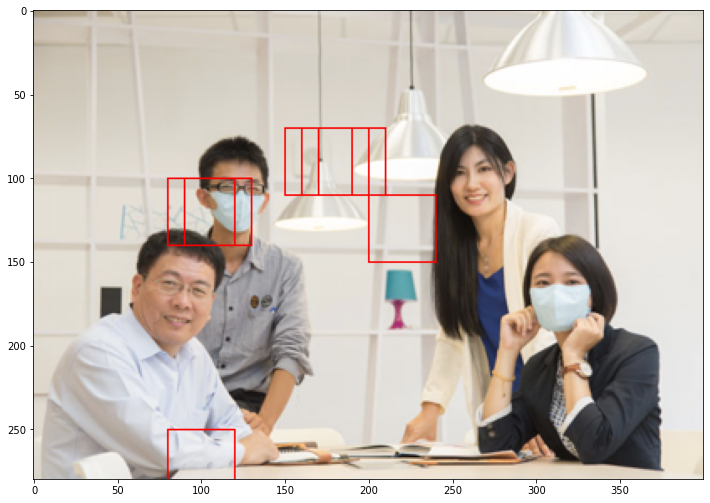

In [22]:
print(score)
print(score_window)

#plotting
for (x,y) in score_window:
    cv2.rectangle(image,(x,y),(x+40,y+40),(0,0,250),1)
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

"""
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,250,0),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)
"""